In [1]:
using Pkg; Pkg.activate()
using Dates
using NeymanScottProcesses
using Distributions
using Random

using Base.Iterators: product
using NeymanScottProcesses: sample_logprobs!

include("dataset_utils.jl")

┌ Info: Precompiling NeymanScottProcesses [880aec8a-aaa2-47cc-8cc8-ae74d37d85b5]
└ @ Base loading.jl:1317
┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1317


compute_empirical_embassy_distribution (generic function with 1 method)

# Set parameters

In [2]:
datadir = "/Users/degleris/Data/cables/"
seed = 1976

min_date = get_dateid(Date(1976, 6, 21))
max_date = get_dateid(Date(1976, 7, 31))
vocab_cutoff = 100
num_bins = 4

alpha = 1.0
gamma = 1.0
;

# Load data

In [3]:
# Load data
cables, embassy_dim, word_dim = 
     construct_cables(datadir, min_date, max_date, vocab_cutoff)

word_distr = load_empirical_word_distribution(datadir)
normalized_word_distr = word_distr ./ sum(word_distr, dims=1)

meta = load_cables_metadata(datadir)

@show length(cables) 
@show embassy_dim word_dim
@show max_date - min_date;

length(cables) = 34732
embassy_dim = 2360
word_dim = 21819
max_date - min_date = 40


In [4]:
max_time = max_date - min_date
bin_size = max_time / num_bins

get_timebin(t) = max(1, ceil(Int, t / bin_size))

continous_times = [c.position for c in cables]

t_arr = get_timebin.(continous_times)
e_arr = [c.embassy for c in cables]
w_arr = [c.words for c in cables]
x_arr = [(t=t, e=e, w=w) for (t, e, w) in zip(t_arr, e_arr, w_arr)]

@show minimum(t_arr) maximum(t_arr);

minimum(t_arr) = 1
maximum(t_arr) = 4


# Model Overview

**Data.** Each cable $x_n = (t_n, e_n, w_n)$ will consist of a time stamp $t_n \in \mathbf [T]$, an embassy label $e_n \in [E]$, and a word count vector $w \in \mathbf N^V$.
Here $T$ is the number of timebins, $E$ is the number of embassies, and $V$ is the size of the vocabulary.
In total, we will observe $N$ cables.

**Model.**
$$
\begin{align}
    \pi_{tk} &\in \Delta^V \sim \mathbf{Dirichlet}(\alpha 1) \\
    \pi_{0e} &\in \Delta^V \sim \mathbf{Dirichlet}(\alpha 1) \\
    \beta_{te} &\in \Delta_{K+1} \sim \mathbf{Dirichlet}(\gamma 1) \\
    \\
    z_n \mid e_n, t_n &\sim \mathbf{Categorical}(\beta_{t_n e_n}) \\
    w_n \mid z_n, e_n, t_n &\sim \mathbf{Multinomial}(\pi_{t_n z_n})
\end{align}
$$
We will set $K = 1$.

**Likelihood.**
The log-likelihood of the model is
$$
\begin{align}
    & \log \ell( \{x\}, \{z\}, \{ \pi \}, \{ \beta \} ) \\
    =&  \sum_{z_n > 0} \log \mathbf{MN}(w_n \mid \pi_{t_n k_n})
    + \sum_{z_n = 0} \log \mathbf{MN}(w_n \mid \pi_{t_n e_n}) \\
    &+ \sum_n \log ((\beta_{t_n e_n})_{z_n}) \\
    &+ \sum_{e, t} \log \mathbf{Dirichlet}(\beta_{t_n e_n}\mid \gamma 1) \\
    &+ \sum_e \log \mathbf{Dirichlet}(\pi_{0e} \mid \alpha 1)
    + \sum_{t, k} \log \mathbf{Dirichlet}(\pi_{tk} \mid \alpha 1)
\end{align}
$$

**Inference.**
$$
\begin{align}
    p(z_n = k | \{ \pi \}, \{ \beta \}, \{ x \}) 
        &\propto (\beta_{t_n e_n})_k\ \mathbf{Multinomial}(w_n \mid \pi_{t_n k}) \\
   p(z_n = 0 | \{ \pi \}, \{ \beta \}, \{ x \}) 
        &\propto (\beta_{t_n e_n})_0\ \mathbf{Multinomial}(w_n \mid \pi_{0 e_n}) \\
   \\
   \beta_{te} \mid \{z\} &\sim \mathbf{Dirichlet}\left(\gamma 1 + \sum_{C(k, t_n, e_n)} u_n\right) \\
   \pi_{tk} \mid \{z\}, \{w\} &\sim \mathbf{Dirichlet}\left( \alpha 1 + \sum_{C(k, t_n, e_n)} w_n \right)
\end{align}
$$
where $u_n$ is the $n$th unit vector and $C(k, t, e) = \{ n :\ z_n = k, t_n = t, e_n = e\}$.

In [5]:
get_K(model) = length(model.β[1, 1]) - 1    

function log_p_bkgd(x, model)
    β, π0 = model.β, model.π0
    return log(β[x.t, x.e][1]) +  logpdf(Multinomial(sum(x.w), π0[x.e]), x.w)
end

function log_p_k(k, x, model)
    β, πk = model.β, model.πk
    return log(β[x.t, x.e][1+k]) +  logpdf(Multinomial(sum(x.w), πk[x.t, k]), x.w)
end

function update_log_probs!(lp, x, model)
    K = get_K(model)
    
    lp[1] = log_p_bkgd(x, model)
    for k in 1:K
        lp[1+k] = log_p_k(k, x, model)
    end
    
    return lp
end

function gibbs_update_z!(xs, zs, model)
    K = length(model.β[1, 1]) - 1
    
    lp = zeros(K+1)
    for i in eachindex(zs)
        update_log_probs!(lp, xs[i], model)        
        zs[i] = sample_logprobs!(lp) - 1
    end
end

function get_counts(xs, zs, model)
    K = get_K(model)
    T, E = size(model.β)
    V = length(xs[1].w)
    
    cluster_counts = zeros(K+1, T, E)
    word_counts = [spzeros(V) for t=1:T, k=1:K]
    bkgd_word_counts = [spzeros(V) for e=1:E]
    
    for (i, x) in enumerate(xs)
        cluster_counts[zs[i]+1, x.t, x.e] += 1
        
        if zs[i] == 0
            bkgd_word_counts[x.e] .+= x.w
        else
            word_counts[x.t, zs[i]] .+= x.w
        end 
    end
    
    return cluster_counts, word_counts, bkgd_word_counts
end
    

function gibbs_update_model!(xs, zs, model, hypers)
    β, π0, πk = model
    α, γ = hypers
    K = get_K(model)
    V = length(πk[1, 1])
    
    # Get empirical statistics
    cluster_sizes, word_counts, bkgd_word_counts = get_counts(xs, zs, model)
            
    # Update parent assignment distributions
    T, E = size(β)
    for (t, e) in product(1:T, 1:E)
        β[t, e] .= rand(Dirichlet(γ .+ cluster_sizes[:, t, e]))
    end
    
    # Update word distributions
    T, K = size(πk)
    for (t, k) in product(1:T, 1:K)
        πk[t, k] .= rand(Dirichlet(α .+ word_counts[t, k]))
    end
    for e in 1:E
        π0[e] .= rand(Dirichlet(α .+ bkgd_word_counts[e]))
    end
end


function log_like(xs, zs, model, hypers)
    β, π0, πk = model
    α, γ = hypers
    
    
    log_like = 0.0
    
    # Likelihood of data given model
    for (i, x) in enumerate(xs)
        if zs[i] == 0
            log_like += logpdf(Multinomial(sum(x.w), π0[x.e]), x.w)
        else
            log_like += logpdf(Multinomial(sum(x.w), πk[x.t, zs[i]]), x.w)
        end
        log_like += log(β[x.t, x.e][zs[i]+1])
    end
        
    # Likelihood of model given priors
    T, E = size(β)
    K = get_K(model)
    β_prior = Dirichlet(K+1, γ)
    for (t, e) in product(1:T, 1:E)
        log_like += logpdf(β_prior, β[t, e])
    end
        
    V = length(π0[1])
    π_prior = Dirichlet(V, α)
    for e in 1:E
        log_like += logpdf(π_prior, π0[e])
    end
        
    for (t, k) in product(1:T, 1:K)
        log_like += logpdf(π_prior, πk[t, k])
    end
    
    return log_like
end

log_like (generic function with 1 method)

# Initialize model

In [6]:
# Data parameters
T = maximum(t_arr)
E = size(word_distr, 2)
V = length(w_arr[1])
N = length(x_arr)

# Model parameters
K = 1
γ = gamma
α = alpha

1.0

In [7]:
Random.seed!(seed)

# Initialize latent variables
β = fill(zeros(K+1), T, E)
for (t, e) in product(1:T, 1:E)
    β[t, e] = rand(Dirichlet(K+1, γ))
end

π0 = fill(zeros(V), E)
for e in 1:E
    π0[e] = rand(Dirichlet(V, α))
end

πk = fill(zeros(V), T, K)
for (t, k) in product(1:T, 1:K)
    πk[t, k] = rand(Dirichlet(V, α))
end

# Initialize parent assignments
zs = fill(0, N)
xs = x_arr

hypers = (α=α, γ=γ)
model = (β=β, π0=π0, πk=πk)
;

# Run inference

In [ ]:
num_samples = 100

z_hist = [copy(zs)]
ll_hist = [log_like(xs, zs, model, hypers)]
println("Log likelihood: $(ll_hist[1])")

for itr in 1:num_samples
    gibbs_update_z!(xs, zs, model)
    gibbs_update_model!(xs, zs, model, hypers)
    
    ll = log_like(xs, zs, model, hypers)
    push!(z_hist, copy(zs))
    push!(ll_hist, ll)
    println("Iteration $itr, Log likelihood: $ll")
end
println()

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317
┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1317


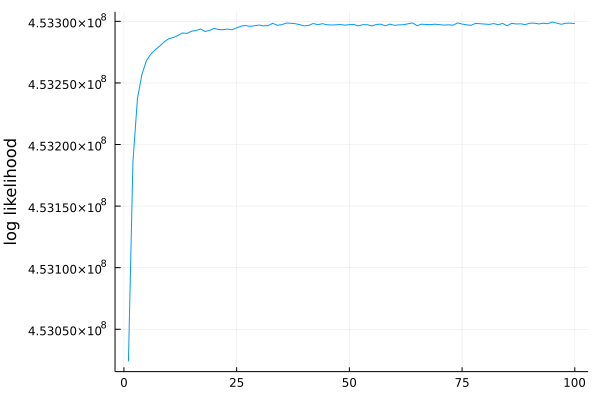

In [11]:
using Plots
plot(ll_hist[2:end], legend=false, ylabel="log likelihood")

# Save results

In [ ]:
using JLD
JLD.@save "baseline.jld" zs model hypers z_hist ll_hist

In [10]:
results = JLD.load("baseline.jld")
z_hist, ll_hist, model, hypers, zs = 
    results["z_hist"], results["ll_hist"], results["model"], results["hypers"], results["zs"];

# Inspect results

In [54]:
function inspect(k, t, zs, xs, model, hypers, meta, word_distr; num_words=30, verbose=true)
    E = length(model.π0)
    
    cluster = xs[(zs .== k) .& ([x.t for x in xs] .== t)]
    words = Float64.(sum([x.w for x in cluster]))
    embassies = [sum([1 for x in cluster if x.e == e]) for e in 1:E]
       
    V0, n = word_distr, size(word_distr, 1)
    words ./= (sum(V0, dims=2)[:, 1] .+ 1/n)  # todo - normalize by embassy
    
    word_ids = sortperm(words, rev=true)[1:num_words]
    relevant_words = join(meta.vocab[word_ids, :word], " -- ")
    if verbose
        @info "cluster $k at time $t:" relevant_words
    end
    
    return meta.vocab[word_ids, :word]
end

inspect (generic function with 4 methods)

In [47]:
event_probs

4-element Vector{Vector{Float64}}:
 [0.5257110084418952, 0.4742889915581041]
 [0.5003554430270084, 0.4996445569729917]
 [0.3972146941809905, 0.6027853058190102]
 [0.6191056505979512, 0.38089434940204814]

In [60]:
embassy_count = [sum(e_arr .== ei) for ei in 1:embassy_dim] / length(e_arr)
event_probs = [sum(β[t, :] .* embassy_count) for t in 1:T]

t_grid = 0 : 0.1 : max_time
total_intensity = (Ci, t) -> [
   get_timebin(tp) == t ? event_probs[t][Ci] : 0.0 for tp in t_grid
]

#156 (generic function with 1 method)

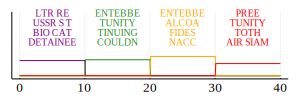

In [107]:
# Make cable intensity plot
theme(:default, label=nothing, tickfont=(8, "times"), guidefont=(8, "times"))
colorset = [:Purple, :ForestGreen, :Orange, :Red]


plt = plot(ylim=(-0.1, 2.0), yticks=nothing)
for t in 1:T
    series_color = colorset[t]

    relevant_words = inspect(1, t; verbose=false)
    relevant_words = filter(w -> 3 < length(w) < 9, relevant_words)
    annotation = text(join(relevant_words[1:4], "\n"), 6, :Times, color=series_color)

    text_height = 1.5  #event_probs[t][2]
    text_center = (t - 0.5) * max_time / T

    plot!(t_grid, total_intensity(2, t), c=series_color)
    annotate!(text_center, text_height, annotation, valign=:top)
end

plot!(plt, size=(300, 100))
savefig(plt, "embassy_results_baseline.pdf")
display(plt)

In [57]:
inspect(k, t; verbose=true) = inspect(k, t, zs, xs, model, hypers, meta, word_distr; verbose=verbose)

for t in 1:T
    inspect(1, t)
    println()
end

┌ Info: cluster 1 at time 1:
│   relevant_words = LTR RE -- USSR S T -- P PROCEDURE -- BIO CAT -- USSR ENVIRONMENTAL AGREEMENT -- DETAINEE -- INTERNATIONAL OPERATIONS -- ANGOLA S -- SPLEX -- VIETNAMESE REFUGEE -- INTERNATIONAL AGREEMENT -- EQUIPMENT TRADE -- ILLICIT PAYMENTS -- INTERCHANGE -- ESTIMATED NUMBER -- FAAS -- IBEX -- POTENTIAL EVACUEES -- ABROAD PROGRAM -- ACTION MEMORANDUM -- GOVERNOR SCRANTON -- HIJACKED -- DROP REPORT -- FALCON -- CREDIT INSURANCE REQUEST -- JOIN REPORT -- SMALL BUSINESS -- RSA SFCP -- GIRAFFE -- FIELD BUDGET
└ @ Main In[54]:14


┌ Info: cluster 1 at time 2:
│   relevant_words = ENTEBBE -- TUNITY -- TINUING -- COULDN -- VERSA -- SOUTH ISSUES -- SINCERELY GERALD -- IRB -- HIJACKERS -- POTASH -- EXCELSIOR -- QUID PRO -- SASKATCHEWAN -- BOIGNY -- MINISTER BHUTTO -- RAID -- BICENTENNIAL -- HOSTAGES -- BELEM -- BORDEAUX AMCONSUL -- UGANDAN -- WEAPON FREE -- SOLES -- WEST BEIRUT -- QUESTED -- ESTIMATED NUMBER -- AMCONSUL STRASBOURG -- AMCONSUL LYON AMCONSUL -- UGANDA -- FORCE BASE
└ @ Main In[54]:14


┌ Info: cluster 1 at time 3:
│   relevant_words = ENTEBBE -- POTENTIAL EVACUEES -- USSR ENVIRONMENTAL -- ESTIMATED NUMBER -- CURRENT HANDLING -- ONLY OFFICIALLY -- GOVERNOR SCRANTON -- ALCOA -- FIDES -- NACC -- MALDONADO -- IRB -- KIP -- AEW -- TUESDAY JULY -- FN -- ICSC -- ROBERTSON -- EXECUTIVE DIRECTORS -- FRIDAY JULY -- SASKATCHEWAN -- IMAM -- AM FLIGHT -- CARBIDE -- MELLE -- ES SALAAM -- CORE GROUP -- CONE -- VEGETABLE -- EXCELSIOR
└ @ Main In[54]:14


┌ Info: cluster 1 at time 4:
│   relevant_words = DE CUELLAR -- IRB -- CORE GROUP -- PASSED ABOVE ADDEE -- ILLICIT PAYMENTS -- UNQUOTE ROBINSON -- PREE -- KOREAN ISSUE -- TUNITY -- SHAPE USCINCEUR -- TOTH -- WEST BEIRUT -- DEBT RELIEF -- AMCONSUL RIO -- AIR SIAM -- OC T PASSED -- MULTILATERAL AFFAIRS -- ENTEBBE -- KOREAN AMBASSADOR -- MORNING JULY -- PUERTO RICO -- COLOMBO -- SELF GOVERNING -- PAF -- ENTRANT -- PURCHASING POWER -- MEMOIRE -- TUESDAY JULY -- FERREIRA -- GOVERNOR SCRANTON
└ @ Main In[54]:14
